# Multiclass Classification

* Find this notebook at `EpyNN/epynnlive/captcha_mnist/train.ipynb`.
* Regular python code at `EpyNN/epynnlive/captcha_mnist/train.py`.

Run the notebook online with [Google Colab](https://colab.research.google.com/github/Synthaze/EpyNN/blob/main/epynnlive/captcha_mnist/train.ipynb).

**Level: Advanced**

In this notebook we will review:

* Handling numerical data image to proceed with Neural Network regression.
* Training of Feed-Forward (FF) and Convolutional Neural Network (CNN) for multiclass classification tasks.
* MNIST database as a benchmark for neural networks.

**It is assumed that all *basics* notebooks were already reviewed:**

* [Basics with Perceptron (P)](../dummy_boolean/train.ipynb)
* [Basics with string sequence](../dummy_string/train.ipynb)
* [Basics with numerical time-series](../dummy_time/train.ipynb)
* [Basics with images](../dummy_image/train.ipynb)

**<font color='red'>This notebook does not enhance, extend or replace EpyNN's documentation.</font>**

**Relevant documentation pages for the current notebook:**

* [Fully Connected (Dense)](https://epynn.net/Dense.html)
* [Convolution (CNN)](https://epynn.net/Convolution.html)
* [Pooling (CNN)](https://epynn.net/Pooling.html)

 Please follow this [external link](http://yann.lecun.com/exdb/mnist/) for detailed contextual information about the MNIST database.

## Environment and data

Follow [this link](prepare_dataset.ipynb) for details about data preparation.

Briefly, the MNIST database contains 70 000 images (60K + 10k).

Each image contains a single handwritten digit. In total, 500 different human writers contributed to the whole.

The MNIST database is curated in that images were size normalized and centered.

In [1]:
# EpyNN/epynnlive/captcha_mnist/train.ipynb
# Install dependencies
!git clone https://github.com/synthaze/EpyNN
!pip3 install -r EpyNN/requirements.txt
import sys
sys.path.insert(1, '/content/EpyNN')

# Standard library imports
import random

# Related third party imports
import matplotlib.pyplot as plt
import numpy as np

# Local application/library specific imports
import epynn.initialize
from epynn.commons.maths import relu, softmax
from epynn.commons.library import (
    configure_directory,
    read_model,
)
from epynn.network.models import EpyNN
from epynn.embedding.models import Embedding
from epynn.convolution.models import Convolution
from epynn.pooling.models import Pooling
from epynn.flatten.models import Flatten
from epynn.dropout.models import Dropout
from epynn.dense.models import Dense
from epynnlive.captcha_mnist.prepare_dataset import (
    prepare_dataset,
    download_mnist,
)
from epynnlive.captcha_mnist.settings import se_hPars


########################## CONFIGURE ##########################
random.seed(1)
np.random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')

configure_directory()


############################ DATASET ##########################
download_mnist()

X_features, Y_label = prepare_dataset(N_SAMPLES=750)

Make: /media/synthase/beta/EpyNN/epynnlive/captcha_mnist/datasets
Make: /media/synthase/beta/EpyNN/epynnlive/captcha_mnist/models
Make: /media/synthase/beta/EpyNN/epynnlive/captcha_mnist/plots
Make: mnist_database.tar


Let's inspect what we retrieved.

In [2]:
print(len(X_features))
print(X_features[0].shape)
print(set(X_features[0].flatten().tolist()))    # Get all unique tones in image

750
(28, 28, 1)
{0.0, 3.0, 6.0, 11.0, 12.0, 13.0, 15.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 27.0, 28.0, 32.0, 39.0, 40.0, 42.0, 43.0, 44.0, 45.0, 46.0, 48.0, 55.0, 67.0, 82.0, 86.0, 87.0, 90.0, 91.0, 94.0, 97.0, 100.0, 101.0, 104.0, 107.0, 110.0, 112.0, 115.0, 116.0, 125.0, 127.0, 129.0, 143.0, 147.0, 150.0, 151.0, 155.0, 158.0, 162.0, 163.0, 166.0, 167.0, 169.0, 170.0, 172.0, 181.0, 183.0, 184.0, 186.0, 189.0, 202.0, 205.0, 206.0, 210.0, 211.0, 214.0, 215.0, 219.0, 220.0, 221.0, 223.0, 225.0, 227.0, 228.0, 230.0, 233.0, 234.0, 237.0, 238.0, 239.0, 240.0, 241.0, 242.0, 243.0, 247.0, 250.0, 252.0, 253.0, 255.0}


We retrieved sample features describing ``750`` samples.

For each sample, we retrieved  features as a three-dimensional array of shape ``(width, height, depth)``. Each image has dimensions of 28x28 and so contains 784 pixels.

In the context, remember that the ``depth`` dimension represents the number of channels which encode the image. While the depth of any RGB image would be equal to 3, the depth of a grayscale image is equal to one. We namely have a regular grayscale image in that shades of gray range from 0 to 255. 

Let's recall how this looks.

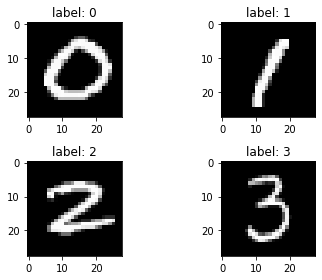

In [3]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)

ax0.imshow(X_features[Y_label.index(0)], cmap='gray')
ax0.set_title('label: 0')

ax1.imshow(X_features[Y_label.index(1)], cmap='gray')
ax1.set_title('label: 1')

ax2.imshow(X_features[Y_label.index(2)], cmap='gray')
ax2.set_title('label: 2')

ax3.imshow(X_features[Y_label.index(3)], cmap='gray')
ax3.set_title('label: 3')

plt.tight_layout()
plt.show()

According to [comments from the authors](http://yann.lecun.com/exdb/mnist/) of the MNIST database: *"The original black and white (bilevel) images from NIST were size normalized \[...\]. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm"*.

## Feed-Forward (FF)

As explained in other examples of network training, we like to begin by a Feed-Forward network each time we start to investigate a new problem. This is because:

* Feed-Forward (Dense-based) networks are computationally faster to train than other architectures.
* Such networks may be less sensitive to training hyperparameters and thus they are easier to train.
* There are no reasonable day/night results depending on the architecture: one Feed-Forward - even if inappropriate - architecture may result in metrics that will not be made two times better by using an appropriate architecture. This mostly depends on hyperparameters and data processing.

About this last item, one may look at the above-linked page which reports on classifier error rate with respect to method or architecture.

As a condensate:

* Single-layer FF (Perceptron) - 12.0% error.
* Single-layer FF (Perceptron) - 7.6% error with deskewing (rotating a scanned image to compensate for skewing).
* Two-layers FF with 800 hidden nodes - 1.6% error.
* Committee of 35 Convolutional Neural Networks (CNN) - 0.23% error (best of all reported).

First, we can see that from the very basic perceptron to the most evolved CNN there is an improvement from 88% to 99.77% accuracy. This is a huge gap, but both architectures succeed at recognizing patterns and drawing a decent model. 

Note that the gap is significantly reduced by simply applying *deskewing* to the image data, which highlights the critical importance of data pre-processing in the ability of the network to result in an accurate model.

Also note that perceptrons are only able of linear regression while multi-layers Feed-Forward or CNN and other architectures can achieve non-linear regressions.

When considering the two-layer Feed-Forward with 800 hidden nodes versus the state-of-the-art CNN, the accuracy goes from 98.4% to 99.77%. Overall, this illustrates that classical Feed-Forward networks may be a good alternative to more appropriate architectures when balancing between accuracy, difficulty of training and need for more computational time.

### Embedding

We start from sample features containing values ranging from 0 to 255.

The most important thing is to **normalize** sample features within \[0, 1\].

The second thing is to set a batch size which, in this case, will make the regression converging faster.

The last - but not least - thing is to one-hot encode the set of sample label. While one may not do this with binary classification problems and thus use a single node in the output dense layer - from which 0 or 1 decisions can be extracted -, the same can not reasonably be done with multiclass classification. Because we have ten distinct labels in the game, the reasonable choice is to use 10 output nodes and to one-hot encode the set of sample label.

In [4]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_scale=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

About data normalization:

* It diminishes the complexity of the problem.
* It accelerates training and makes it easier.
* If no normalization is done in this example, the loss function and gradients will both readily explode and generate floating points errors.

About this last point, remember that exponentials are used in the context of neural networks. If you begin feeding exponential functions with large numbers such as 255, you can be sure you will get floatting points errors pretty quickly: the computer typically deals with 64-bits float number, which has a maximal value of ``1.8 * 10 ** 308``. 

Note that in previously used 32-bits processors architecture, this maximal value was down to ``3.4 * 10 ** 38``. Compare with ``exp(255)`` which outputs ``5.56 * 10 ** 110`` and conclude that un-normalized data in the context of this notebook would have overflowed straight away on a - not that ancient - 32-bits system. Actually, if you attempt to run this notebook on a [Raspberry Pi](https://www.raspberrypi.org/) - why not? - you would overflow without normalization because the device relies on 32-bits CPUs.  

### Flatten-(Dense)n with Dropout

We already explained why we need to use a *flatten* layer when attempting to forward arrays of more than 2 dimensions to the *dense* layer: image data have three dimensions, and the array of sample features - the array of sample images - has four dimensions. Therefore we need to flatten this array to give it a bi-dimensional shape.

In [5]:
name = 'Flatten_Dropout02_Dense-64-relu_Dropout05_Dense-10-softmax'

se_hPars['learning_rate'] = 0.001
se_hPars['softmax_temperature'] = 5

flatten = Flatten()

dropout1 = Dropout(drop_prob=0.2)

hidden_dense = Dense(64, relu)

dropout2 = Dropout(drop_prob=0.5)

dense = Dense(10, softmax)

layers = [embedding, flatten, dropout1, hidden_dense, dropout2, dense]

model = EpyNN(layers=layers, name=name)

We have set up a custom learning rate, along with the 10 units in the output layers because we have labels one-hot encoded over 10 digits and again because we have ten distinct labels.

Dropout layers were set to reduce overfitting and the *softmax temperature* was set higher than one to smooth the output probability distribution which practically results in more numerically stable training.

In [6]:
model.initialize(loss='CCE', seed=1, se_hPars=se_hPars.copy(), end='\r')

We have set the loss function to use *Categorical Cross Entropy* instead of *Binary Cross Entropy*. This is because we have ten distinct labels instead of two.

In [7]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 14/14 - Accuracy: 0.906 Cost: 0.36511 - TIME: 15.75s RATE: 6.35e+00e/s TTC: 0s     

+-------+----------+----------+----------+-------+--------+-------+-----------------------------------------------------------------------+
| epoch |  lrate   |  lrate   | accuracy |       |  CCE   |       |                              Experiment                               |
|       |  Dense   |  Dense   |  dtrain  | dval  | dtrain | dval  |                                                                       |
+-------+----------+----------+----------+-------+--------+-------+-----------------------------------------------------------------------+
|   0   | 1.00e-03 | 1.00e-03 |  0.240   | 0.220 | 2.235  | 2.239 | 1635012330_Flatten_Dropout02_Dense-64-relu_Dropout05_Dense-10-softmax |
|  10   | 1.00e-03 | 1.00e-03 |  0.700   | 0.664 | 1.155  | 1.258 | 1635012330_Flatten_Dropout02_Dense-64-relu_Dropout05_Dense-10-softmax |
|  20   | 1.00e-03 | 1.00e-03 |  0.798   | 0.740 | 0.741  

Again the Feed-Forward network has been quite performant to reproduce the training data, less about the validation ones. Overfitting is a general problem in the field.

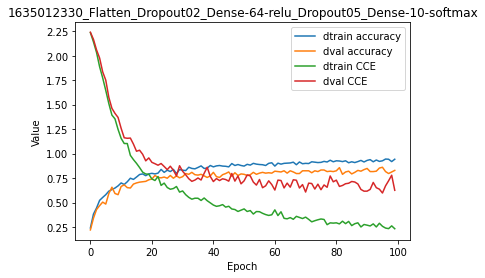

In [8]:
model.plot(path=False)

We will not optimize this Feed-Forward model and instead we will go ahead with Convolutional networks.

## Convolutional Neural Network (CNN)

As detailed in [Basics with images](epynnlive/dummy_image/train.html#Convolutional-Neural-Network-(CNN)), CNNs are preferred when it comes to considering *a priori* spatial relationships between data points.

### Embedding

Using same embedding configuration as above.

In [9]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_scale=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

Note that we use only *500 + 250* sample images herein. Benchmarks using the MNIST Database generally employ the whole 60 000 images for the training set itself, but it is likely to overload the RAM or not run at all on many system configurations. 

### Conv-MaxPool-Flatten-Dense

Using a single *Convolution-Pooling* block with ``16`` filters and *4x4* filter window for the *Convolution* layer.

In [10]:
name = 'Convolution-16-2_Pooling-3-Max_Flatten_Dense-10-softmax'

se_hPars['learning_rate'] = 0.005
se_hPars['softmax_temperature'] = 5

layers = [
    embedding,
    Convolution(unit_filters=16, filter_size=(2, 2), activate=relu),
    Pooling(pool_size=(2, 2)),
    Flatten(),
    Dense(10, softmax)
]

model = EpyNN(layers=layers, name=name)

Initialize the model with *Categorical Cross Entropy* loss.

In [11]:
model.initialize(loss='CCE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Train for 20 epochs.

In [12]:
model.train(epochs=10, init_logs=False)

Epoch 9 - Batch 14/14 - Accuracy: 0.75 Cost: 0.52838 - TIME: 7.37s RATE: 1.36e+00e/s TTC: 1s        

+-------+-------------+----------+----------+-------+--------+-------+--------------------------------------------------------------------+
| epoch |    lrate    |  lrate   | accuracy |       |  CCE   |       |                             Experiment                             |
|       | Convolution |  Dense   |  dtrain  | dval  | dtrain | dval  |                                                                    |
+-------+-------------+----------+----------+-------+--------+-------+--------------------------------------------------------------------+
|   0   |  5.00e-03   | 5.00e-03 |  0.594   | 0.564 | 1.880  | 1.916 | 1635012346_Convolution-16-2_Pooling-3-Max_Flatten_Dense-10-softmax |
|   1   |  5.00e-03   | 5.00e-03 |  0.728   | 0.716 | 1.083  | 1.149 | 1635012346_Convolution-16-2_Pooling-3-Max_Flatten_Dense-10-softmax |
|   2   |  5.00e-03   | 5.00e-03 |  0.770   | 0.728 | 0.76

The overfitting using this CNN architecture is reduced compared with the pure Feed-Forward design. However, accuracy remains slightly lower for both training and validation data.

Note the ``learning_rate`` may be a bit too high here: there are jumps up and down for both accuracy and loss, particularly visible on the validation set.

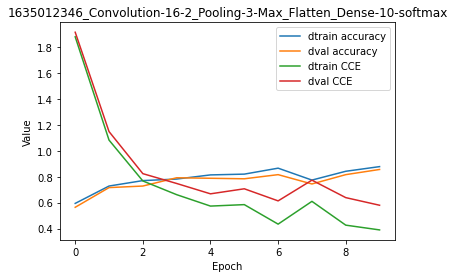

In [13]:
model.plot(path=False)

Looking at the plot, the model seems to have converged.

We will try to optimize it further.

### Conv-MaxPool-Flatten-(Dense)n

Below we added one ``Dense(64, relu)`` hidden layer. This is the same design as used for the Feed-Forward network excepted, of course, for the *Convolution-Pooling* block. The thing to pay attention to here is the absence of *Dropout* layer compared to the Feed-Forward network.

Epoch 9 - Batch 14/14 - Accuracy: 0.906 Cost: 0.5155 - TIME: 9.21s RATE: 1.09e+00e/s TTC: 2s        

+-------+-------------+----------+----------+----------+-------+--------+-------+----------------------------------------------------------------------------------+
| epoch |    lrate    |  lrate   |  lrate   | accuracy |       |  CCE   |       |                                    Experiment                                    |
|       | Convolution |  Dense   |  Dense   |  dtrain  | dval  | dtrain | dval  |                                                                                  |
+-------+-------------+----------+----------+----------+-------+--------+-------+----------------------------------------------------------------------------------+
|   0   |  5.00e-03   | 5.00e-03 | 5.00e-03 |  0.570   | 0.520 | 1.822  | 1.863 | 1635012353_Convolution-16-2_Pooling-3-Max_Flatten_Dense-64-relu_Dense-10-softmax |
|   1   |  5.00e-03   | 5.00e-03 | 5.00e-03 |  0.628   | 0.564 | 1.172  |

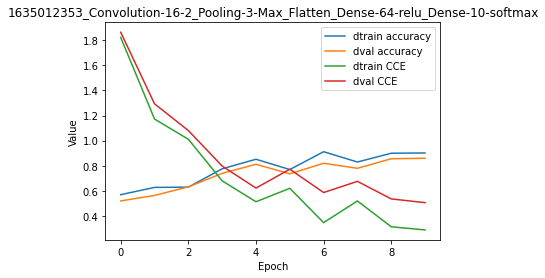

In [14]:
name = 'Convolution-16-2_Pooling-3-Max_Flatten_Dense-64-relu_Dense-10-softmax'

se_hPars['learning_rate'] = 0.005
se_hPars['softmax_temperature'] = 5

layers = [
    embedding,
    Convolution(unit_filters=16, filter_size=(2, 2), activate=relu),
    Pooling(pool_size=(2, 2)),
    Flatten(),
    Dense(64, relu),
    Dense(10, softmax)
]

model = EpyNN(layers=layers, name=name)

model.initialize(loss='CCE', seed=1, se_hPars=se_hPars.copy(), end='\r')

model.train(epochs=10, init_logs=False)

model.plot(path=False)

This result is better than the one obtained with the Feed-Forward network. Although we did not use *Dropout* regularization, there is less overfitting and higher accuracy on the validation set.

For code, maths and pictures behind the convolution and pooling layers, follow these links:

* [Convolution (CNN)](https://epynn.net/Convolution.html)
* [Pooling (CNN)](https://epynn.net/Pooling.html)

## Write, read & Predict

A trained model can be written on disk such as:

In [15]:
model.write()

# model.write(path=/your/custom/path)

Make: /media/synthase/beta/EpyNN/epynnlive/captcha_mnist/models/1635012353_Convolution-16-2_Pooling-3-Max_Flatten_Dense-64-relu_Dense-10-softmax.pickle


A model can be read from disk such as:

In [16]:
model = read_model()

# model = read_model(path=/your/custom/path)

We can retrieve new features and predict on them.

In [17]:
X_features, _ = prepare_dataset(N_SAMPLES=10)

dset = model.predict(X_features, X_scale=True)

Results can be extracted such as:

In [18]:
for n, pred, probs in zip(dset.ids, dset.P, dset.A):
    print(n, pred, probs)

0 4 [1.31587431e-03 4.08317943e-05 1.30351360e-03 1.47063124e-03
 9.78023255e-01 1.93182534e-03 1.40558825e-03 3.30961357e-04
 4.94257777e-04 1.36832613e-02]
1 1 [7.28977838e-05 9.29707175e-01 3.32038257e-02 1.98144195e-03
 2.40938005e-04 1.34165640e-02 1.50138537e-03 1.67654867e-03
 1.77799721e-02 4.19250987e-04]
2 3 [4.78064492e-03 3.29830971e-06 1.58072929e-03 9.54198963e-01
 6.41479062e-05 1.35982207e-02 5.87131031e-06 3.48727032e-05
 2.55519849e-02 1.81267435e-04]
3 3 [4.14994350e-03 2.29267766e-03 1.15714086e-02 5.79869691e-01
 3.52961208e-04 6.38732938e-02 1.03465443e-04 9.56096045e-03
 3.23308022e-01 4.91757634e-03]
4 1 [4.89436878e-06 9.80078656e-01 1.78383500e-03 7.31766268e-06
 7.22962122e-05 1.67800975e-04 1.39517610e-04 3.73043330e-04
 1.73534589e-02 1.91798796e-05]
5 4 [1.27447904e-03 3.62544371e-03 1.60817813e-02 5.22806853e-04
 5.99689165e-01 3.52024299e-01 1.56190299e-02 1.34865787e-04
 8.51033165e-03 2.51779700e-03]
6 2 [4.34791238e-02 5.76774386e-03 8.07714111e-01 1.